In [65]:
import sqlite3
from IPython.display import HTML, display

db = 'file:results.db?mode=ro'
con = sqlite3.connect(db, uri=True)

cur = con.cursor()
cur.execute("SELECT * FROM runs WHERE description LIKE '%scaling%'")

def display_result(cur, data=cur.fetchall()):
    html = "<table>"
    headers = list(map(lambda x: x[0], cur.description))
    
    html += "<thead><tr>" + "".join(["<td>" + h + "</td>" for h in headers]) + "</tr></thead>"
    for row in data:
        html += "<tr>"
        for field in row:
            html += "<td>%s</td>"%(field)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))
display_result(cur)

id,date,hostname,revision,cluster_size,description,flags
21,2021-12-14 14:38:53,i10pc138,caae9e9ec5aac44a8b29bab1d8911f246c244264,256,strong scaling,
22,2021-12-14 14:44:51,i10pc138,caae9e9ec5aac44a8b29bab1d8911f246c244264,256,weak scaling,


## Strong scaling

In [133]:
benchmark_id = 22

<IPython.core.display.Javascript object>


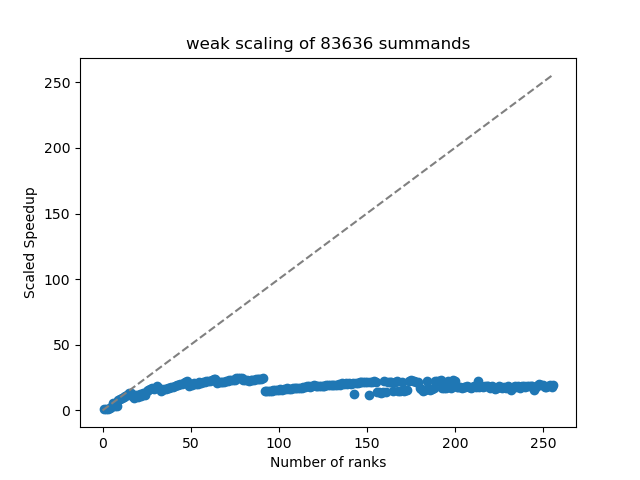

In [134]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

cur.execute("SELECT description FROM runs WHERE id = ?", (benchmark_id,))
description = cur.fetchone()[0]

weak_scaling = (description == "weak scaling")

f = plt.figure()
ax = f.subplots(1)
ax.set_xlabel("Number of ranks")
ax.set_ylabel(("Scaled " if weak_scaling else "") + "Speedup")

cur.execute("SELECT time_ns, n_summands FROM results WHERE run_id=? AND ranks = 1", (benchmark_id,))
r = cur.fetchone()
sequential_time = r[0] * 1e-9

ax.set_title(f"{description} of {r[1]} summands")

cur.execute("SELECT ranks, time_ns FROM results WHERE run_id = ? AND ranks > 1 ORDER BY ranks", [benchmark_id])

X = [1] # core count
Y = [1] # speed-up

for row in cur.fetchall():
    X.append(row[0])
    parallel_time = row[1] * 1e-9
    speedup = sequential_time / parallel_time
    if weak_scaling:
        speedup *= row[0]
    Y.append(speedup)

plt.scatter(X, Y)
#plt.plot(X, Y)

plt.plot([0,max(X)], [0,max(X)], "--", color='gray')
plt.savefig("weak_scaling_256.svg")
plt.show()